# TL09: Fine-tuning con PEFT (Parameter-Efficient Fine-Tuning)

Este notebook introduce el uso de PEFT (Parameter-Efficient Fine-Tuning) para realizar fine-tuning eficiente de modelos de deep learning. PEFT permite entrenar solo una pequeña fracción de los parámetros del modelo, reduciendo significativamente el coste computacional y de memoria.

## Sección 1: Fine-tuning con LoRA de un MLP

En esta primera sección, aprenderemos los conceptos básicos de LoRA (Low-Rank Adaptation) aplicándolo a un modelo MLP (Multilayer Perceptron) simple. Compararemos el entrenamiento tradicional con el entrenamiento usando LoRA.


In [ ]:
# Importación de librerías necesarias
# - copy: para hacer copias profundas del modelo original
# - os: para configurar variables de entorno
# - peft: librería de Hugging Face para fine-tuning eficiente de parámetros
# - torch: PyTorch para operaciones de deep learning
# - nn: módulo de PyTorch para capas y modelos de red neuronal
# - F: funciones funcionales de PyTorch
import copy; import os; import peft; import torch; from torch import nn; import torch.nn.functional as F
# Suprimir advertencias de bitsandbytes (librería opcional para cuantización)
os.environ["BITSANDBYTES_NOWELCOME"] = "1" # ignore bnb warnings

In [ ]:
# Creación del dataset sintético para el ejemplo
# Fijamos la semilla aleatoria para reproducibilidad
torch.manual_seed(0)
# Generamos 1000 vectores aleatorios de 20 dimensiones
X = torch.rand((1000, 20))
# Creamos etiquetas binarias: clase 1 si la suma de características > 10, sino clase 0
y = (X.sum(1) > 10).long()

# División del dataset: 800 muestras para entrenamiento, 200 para evaluación
n_train = 800
batch_size = 64

# Creación de dataloaders para entrenamiento y evaluación
# El dataloader de entrenamiento mezcla los datos (shuffle=True)
train_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[:n_train], y[:n_train]),
 batch_size=batch_size, shuffle=True)
eval_dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[n_train:], y[n_train:]),
 batch_size=batch_size)

# Visualizamos una muestra del dataset
X[0], y[0]

(tensor([0.4963, 0.7682, 0.0885, 0.1320, 0.3074, 0.6341, 0.4901, 0.8964, 0.4556,
         0.6323, 0.3489, 0.4017, 0.0223, 0.1689, 0.2939, 0.5185, 0.6977, 0.8000,
         0.1610, 0.2823]),
 tensor(0))

In [ ]:
# Definición del modelo MLP (Multilayer Perceptron)
# El modelo tiene:
# - Capa de entrada: 20 características -> 2000 unidades ocultas
# - Primera capa oculta: 2000 -> 2000 unidades con activación ReLU
# - Segunda capa oculta: 2000 -> 2000 unidades con activación ReLU
# - Capa de salida: 2000 -> 2 clases (clasificación binaria) con LogSoftmax
class MLP(nn.Module):
 def __init__(self, num_units_hidden=2000):
  super().__init__()
  self.seq = nn.Sequential(
    nn.Linear(20, num_units_hidden), nn.ReLU(),
    nn.Linear(num_units_hidden, num_units_hidden), nn.ReLU(),
    nn.Linear(num_units_hidden, 2), nn.LogSoftmax(dim=-1))
 def forward(self, X):
  return self.seq(X)

In [ ]:
# Configuración de hiperparámetros para el entrenamiento
lr = 0.002  # Learning rate (tasa de aprendizaje)
batch_size = 64  # Tamaño del lote
max_epochs = 10  # Número máximo de épocas

# Detección automática del dispositivo (GPU si está disponible, sino CPU)
# torch.accelerator es parte de la librería accelerate de Hugging Face
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device

'cuda'

In [ ]:
# Función de entrenamiento básica
# Esta función entrena el modelo durante un número determinado de épocas
# y evalúa el rendimiento en cada época
def train(model, optimizer, criterion, train_dataloader, eval_dataloader, epochs):
 for epoch in range(epochs):
  # Modo de entrenamiento: activa dropout, batch normalization, etc.
  model.train()
  train_loss = 0

  # Bucle de entrenamiento: procesa todos los lotes del conjunto de entrenamiento
  for xb, yb in train_dataloader:
   # Mover datos al dispositivo (GPU/CPU)
   xb = xb.to(device); yb = yb.to(device)
   # Forward pass: obtener predicciones del modelo
   outputs = model(xb)
   # Calcular pérdida
   loss = criterion(outputs, yb)
   train_loss += loss.detach().float()
   # Backward pass: calcular gradientes
   loss.backward()
   # Actualizar pesos usando el optimizador
   optimizer.step()
   # Limpiar gradientes para el siguiente lote
   optimizer.zero_grad()

  # Modo de evaluación: desactiva dropout, batch normalization en modo eval
  model.eval()
  eval_loss = 0

  # Bucle de evaluación: procesa todos los lotes del conjunto de evaluación
  for xb, yb in eval_dataloader:
   xb = xb.to(device); yb = yb.to(device)
   # No calcular gradientes durante la evaluación (ahorra memoria y tiempo)
   with torch.no_grad():
     outputs = model(xb)
   loss = criterion(outputs, yb)
   eval_loss += loss.detach().float()

  # Calcular pérdidas promedio
  eval_loss_total = (eval_loss / len(eval_dataloader)).item()
  train_loss_total = (train_loss / len(train_dataloader)).item()
  # Imprimir métricas de la época
  print(f"{epoch=:<2} {train_loss_total=:.4f} {eval_loss_total=:.4f}")

### Entrenamiento sin LoRA (Fine-tuning tradicional)

En este caso, entrenamos todos los parámetros del modelo. Esto requiere más memoria y tiempo computacional.


In [ ]:
# Crear instancia del modelo MLP y moverlo al dispositivo (GPU/CPU)
module = MLP().to(device)
# Crear optimizador Adam que actualizará TODOS los parámetros del modelo
optimizer = torch.optim.Adam(module.parameters(), lr=lr)
# Función de pérdida para clasificación: CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

In [ ]:
# Entrenar el modelo sin LoRA (fine-tuning tradicional)
# %time mide el tiempo de ejecución de la celda
%time train(module, optimizer, criterion, train_dataloader, eval_dataloader, epochs=max_epochs)

epoch=9  train_loss_total=0.7970 eval_loss_total=0.6472
CPU times: user 119 ms, sys: 89.5 ms, total: 208 ms
Wall time: 617 ms


### Entrenamiento con LoRA

Ahora aplicaremos LoRA al modelo. LoRA añade matrices de bajo rango a ciertas capas del modelo, permitiendo entrenar solo una pequeña fracción de parámetros mientras mantenemos el rendimiento.


In [ ]:
# Inspeccionar la estructura del modelo MLP
# Esto nos ayuda a identificar los nombres de los módulos para configurar LoRA
# Necesitamos conocer los nombres exactos de las capas que queremos adaptar con LoRA
[(n, type(m)) for n, m in MLP().named_modules()]

[('', __main__.MLP),
 ('seq', torch.nn.modules.container.Sequential),
 ('seq.0', torch.nn.modules.linear.Linear),
 ('seq.1', torch.nn.modules.activation.ReLU),
 ('seq.2', torch.nn.modules.linear.Linear),
 ('seq.3', torch.nn.modules.activation.ReLU),
 ('seq.4', torch.nn.modules.linear.Linear),
 ('seq.5', torch.nn.modules.activation.LogSoftmax)]

In [ ]:
# Configuración de LoRA
# - r=8: rango de las matrices de bajo rango (rank). Valores más bajos = menos parámetros entrenables
# - target_modules: capas donde se aplicará LoRA (seq.0 y seq.2 son las capas lineales ocultas)
# - modules_to_save: módulos que se guardarán completamente (seq.4 es la capa de salida)
#   Estos módulos se entrenan completamente, no solo con LoRA
config = peft.LoraConfig(r=8, target_modules=["seq.0", "seq.2"], modules_to_save=["seq.4"])

In [ ]:
# Crear una nueva instancia del modelo MLP
module = MLP().to(device)
# Guardar una copia del modelo original para comparación posterior
# Esto nos permitirá verificar qué parámetros se actualizaron
module_copy = copy.deepcopy(module) # we keep a copy of the original model for later

# Aplicar LoRA al modelo usando la configuración definida
# get_peft_model envuelve el modelo original y añade los adaptadores LoRA
peft_model = peft.get_peft_model(module, config)

# Crear optimizador que solo actualizará los parámetros entrenables (LoRA + modules_to_save)
optimizer = torch.optim.Adam(peft_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Mostrar estadísticas de parámetros entrenables
# Veremos que solo una pequeña fracción de parámetros son entrenables
peft_model.print_trainable_parameters()

trainable params: 52,162 || all params: 4,100,164 || trainable%: 1.2722


In [ ]:
# Entrenar el modelo con LoRA
# Nota: el tiempo de entrenamiento debería ser menor que el fine-tuning tradicional
# porque solo estamos actualizando una pequeña fracción de parámetros
%time train(peft_model, optimizer, criterion, train_dataloader, eval_dataloader, epochs=max_epochs)

epoch=9  train_loss_total=0.6943 eval_loss_total=0.6561
CPU times: user 59.6 ms, sys: 819 µs, total: 60.5 ms
Wall time: 83.8 ms


### Análisis del efecto de LoRA

A continuación, analizamos qué parámetros se añadieron con LoRA y cuáles parámetros originales se actualizaron.


In [ ]:
# Inspeccionar los nuevos parámetros añadidos por LoRA
# LoRA añade dos matrices por capa objetivo: lora_A (down-projection) y lora_B (up-projection)
# El producto lora_B @ lora_A es una matriz de bajo rango que se añade a la capa original
for name, param in peft_model.base_model.named_parameters():
 if "lora" not in name:
  continue
 print(f"New parameter {name:<13} | {param.numel():>5} parameters | updated")

New parameter model.seq.0.lora_A.default.weight |   160 parameters | updated
New parameter model.seq.0.lora_B.default.weight | 16000 parameters | updated
New parameter model.seq.2.lora_A.default.weight | 16000 parameters | updated
New parameter model.seq.2.lora_B.default.weight | 16000 parameters | updated


In [ ]:
# Comparar los parámetros originales con los parámetros después del entrenamiento
# Esto nos permite verificar qué parámetros se actualizaron y cuáles permanecieron congelados
params_before = dict(module_copy.named_parameters())
for name, param in peft_model.base_model.named_parameters():
 # Saltar parámetros LoRA (ya los inspeccionamos antes)
 if "lora" in name:
  continue
 # Limpiar el nombre del parámetro para compararlo con el modelo original
 name_before = (name.partition(".")[-1].replace("base_layer.", "").replace("original_", "")\
  .replace("module.", "").replace("modules_to_save.default.", ""))
 param_before = params_before[name_before]
 # Comparar si el parámetro cambió (con tolerancia numérica)
 if torch.allclose(param, param_before):
  print(f"Parameter {name_before:<13} | {param.numel():>7} parameters | not updated")
 else:
  print(f"Parameter {name_before:<13} | {param.numel():>7} parameters | updated")

Parameter seq.0.weight  |   40000 parameters | not updated
Parameter seq.0.bias    |    2000 parameters | not updated
Parameter seq.2.weight  | 4000000 parameters | not updated
Parameter seq.2.bias    |    2000 parameters | not updated
Parameter seq.4.weight  |    4000 parameters | not updated
Parameter seq.4.bias    |       2 parameters | not updated
Parameter seq.4.weight  |    4000 parameters | updated
Parameter seq.4.bias    |       2 parameters | updated


## Sección 2: Fine-tuning con LoRA de un ViT para Food101

En esta sección aplicaremos LoRA a un modelo Vision Transformer (ViT) pre-entrenado para clasificación de imágenes del dataset Food101. Este es un ejemplo más realista que muestra cómo usar LoRA con modelos de transformers.


In [ ]:
# Importación de librerías para el ejemplo con Vision Transformer
# - numpy: operaciones numéricas
# - torch: PyTorch
# - transformers: librería de Hugging Face para modelos pre-entrenados
# - evaluate: métricas de evaluación
# - accelerate: aceleración de entrenamiento
# - peft: fine-tuning eficiente de parámetros
import numpy as np; import torch; import transformers; import evaluate; import accelerate; import peft

In [ ]:
# Modelo pre-entrenado: Vision Transformer base de Google
# Este modelo fue pre-entrenado en ImageNet-21k (14 millones de imágenes, 21k clases)
# Patch size: 16x16, tamaño de imagen de entrada: 224x224
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [ ]:
# Cargar el dataset Food101
# Food101 contiene 101 clases de comida diferentes
# Para este ejemplo, usamos solo 5000 muestras para acelerar el entrenamiento
from datasets import load_dataset
full_dataset = load_dataset("food101", split="train")
# Mezclar y seleccionar 5000 muestras aleatorias
dataset = full_dataset.shuffle(seed=7).select(range(5000))
del full_dataset  # Liberar memoria del dataset completo

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00008.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

data/train-00001-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00002-of-00008.parquet:   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00003-of-00008.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00004-of-00008.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

data/train-00005-of-00008.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

data/train-00006-of-00008.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00007-of-00008.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/validation-00000-of-00003.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

data/validation-00001-of-00003.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/validation-00002-of-00003.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
# Crear mapeos entre etiquetas y IDs
# El modelo necesita convertir nombres de clases a IDs numéricos y viceversa
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
 label2id[label] = i  # Mapeo: nombre de clase -> ID numérico
 id2label[i] = label  # Mapeo: ID numérico -> nombre de clase

In [ ]:
# Cargar el procesador de imágenes asociado al modelo
# El procesador se encarga de normalizar, redimensionar y preprocesar las imágenes
# para que tengan el formato esperado por el modelo ViT
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
# Definir transformaciones de datos para entrenamiento y validación
# Las transformaciones de entrenamiento incluyen data augmentation para mejorar la generalización
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop,
 Resize, ToTensor)

# Normalización usando las estadísticas del modelo pre-entrenado
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# Transformaciones para entrenamiento: incluyen data augmentation
# - RandomResizedCrop: recorte aleatorio y redimensionado (aumenta variabilidad)
# - RandomHorizontalFlip: volteo horizontal aleatorio (aumenta variabilidad)
# - ToTensor: convierte PIL Image a tensor
# - normalize: normaliza los valores de píxeles
train_transforms = Compose([RandomResizedCrop(image_processor.size["height"]),
 RandomHorizontalFlip(), ToTensor(), normalize])

# Transformaciones para validación: sin data augmentation
# - Resize: redimensiona la imagen
# - CenterCrop: recorte central
# - ToTensor y normalize: igual que en entrenamiento
val_transforms = Compose([Resize(image_processor.size["height"]), CenterCrop(image_processor.size["height"]),
 ToTensor(), normalize])

# Función para preprocesar lotes de entrenamiento
def preprocess_train(example_batch):
 """Apply train_transforms across a batch."""
 example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
 return example_batch

# Función para preprocesar lotes de validación
def preprocess_val(example_batch):
 """Apply val_transforms across a batch."""
 example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
 return example_batch

# Dividir el dataset en entrenamiento (90%) y validación (10%)
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

# Aplicar las transformaciones correspondientes a cada conjunto
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
# Cargar el modelo ViT pre-entrenado para clasificación de imágenes
# El modelo se adapta automáticamente al número de clases del dataset (101 clases de Food101)
# La capa clasificadora se inicializa aleatoriamente ya que el modelo original tiene 21k clases
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model = AutoModelForImageClassification.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Función auxiliar para contar parámetros entrenables
# Útil para comparar el número de parámetros antes y después de aplicar LoRA
def print_trainable_parameters(model):
 """
 Prints the number of trainable parameters in the model.
 """
 trainable_params = 0
 all_param = 0
 for _, param in model.named_parameters():
  all_param += param.numel()  # Contar todos los parámetros
  if param.requires_grad:  # Contar solo los parámetros entrenables
    trainable_params += param.numel()
 print(f"trainable params: {trainable_params} || all params: {all_param} ||",
  f"trainable%: {100 * trainable_params / all_param:.2f}")

In [ ]:
# Verificar cuántos parámetros son entrenables en el modelo original
# En este caso, todos los parámetros son entrenables (100%)
print_trainable_parameters(model)

trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


In [ ]:
# Configurar LoRA para el modelo ViT
# - r=16: rango de las matrices de bajo rango (mayor que en el ejemplo MLP)
# - lora_alpha=16: factor de escalado para los pesos LoRA (suele ser igual a r)
# - target_modules=["query", "value"]: aplicar LoRA a las capas de atención query y value
#   (estas son las capas más importantes en los transformers)
# - lora_dropout=0.1: dropout aplicado a los adaptadores LoRA (regularización)
# - bias="none": no entrenar los bias (solo entrenar los pesos LoRA)
# - modules_to_save=["classifier"]: entrenar completamente la capa clasificadora
from peft import LoraConfig, get_peft_model
config = LoraConfig(
 r=16,
 lora_alpha=16,
 target_modules=["query", "value"],
 lora_dropout=0.1,
 bias="none",
 modules_to_save=["classifier"])
# Aplicar LoRA al modelo
lora_model = get_peft_model(model, config)

In [ ]:
# Verificar cuántos parámetros son entrenables después de aplicar LoRA
# Deberíamos ver una reducción dramática (de ~85M a ~667K parámetros, ~0.77%)
print_trainable_parameters(lora_model)

trainable params: 667493 || all params: 86543818 || trainable%: 0.77


In [ ]:
# Configurar los argumentos de entrenamiento usando la API Trainer de Hugging Face
# Trainer simplifica el proceso de entrenamiento y maneja automáticamente muchas tareas
from transformers import TrainingArguments, Trainer
model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
 f"{model_name}-finetuned-lora-food101",  # Directorio donde se guardarán los checkpoints
 remove_unused_columns=False,  # No eliminar columnas no usadas del dataset
 eval_strategy="epoch",  # Evaluar al final de cada época
 save_strategy="epoch",  # Guardar checkpoint al final de cada época
 learning_rate=5e-3,  # Tasa de aprendizaje (relativamente alta para LoRA)
 per_device_train_batch_size=batch_size,  # Tamaño de lote por dispositivo
 gradient_accumulation_steps=4,  # Acumular gradientes de 4 lotes antes de actualizar
 per_device_eval_batch_size=batch_size,  # Tamaño de lote para evaluación
 fp16=True,  # Usar precisión mixta (float16) para acelerar entrenamiento y ahorrar memoria
 num_train_epochs=10,  # Número de épocas
 logging_steps=10,  # Registrar métricas cada 10 pasos
 load_best_model_at_end=True,  # Cargar el mejor modelo al finalizar
 metric_for_best_model="accuracy",  # Métrica para determinar el mejor modelo
 push_to_hub=False,  # No subir el modelo al Hub de Hugging Face
 label_names=["labels"])  # Nombre de la columna de etiquetas

In [ ]:
# Cargar la métrica de precisión (accuracy)
metric = evaluate.load("accuracy")

# Función para calcular métricas durante la evaluación
# El Trainer llama a esta función automáticamente después de cada evaluación
def compute_metrics(eval_pred):
 """Computes accuracy on a batch of predictions"""
 # Obtener las predicciones (índice de la clase con mayor probabilidad)
 predictions = np.argmax(eval_pred.predictions, axis=1)
 # Calcular y devolver la precisión
 return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
# Función para agrupar (collate) ejemplos en un lote
# Convierte una lista de ejemplos en un diccionario con tensores batch
def collate_fn(examples):
 # Apilar todas las imágenes en un tensor batch
 pixel_values = torch.stack([example["pixel_values"] for example in examples])
 # Convertir las etiquetas en un tensor
 labels = torch.tensor([example["label"] for example in examples])
 return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Crear el objeto Trainer que manejará todo el proceso de entrenamiento
# Trainer se encarga de:
# - Iterar sobre los datos de entrenamiento
# - Calcular pérdidas y gradientes
# - Actualizar los pesos del modelo
# - Evaluar el modelo periódicamente
# - Guardar checkpoints
trainer = Trainer(
 lora_model,  # Modelo a entrenar (con LoRA aplicado)
 args,  # Argumentos de entrenamiento
 train_dataset=train_ds,  # Dataset de entrenamiento
 eval_dataset=val_ds,  # Dataset de validación
 processing_class=image_processor,  # Procesador de imágenes (para inferencia)
 compute_metrics=compute_metrics,  # Función para calcular métricas
 data_collator=collate_fn)  # Función para agrupar ejemplos en lotes

# Iniciar el entrenamiento
train_results = trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nadiva1243 (nadiva1243-universitat-polit-cnica-de-val-ncia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.393600,0.694000
2,3.553700,1.247794,0.738000
3,1.618700,0.997934,0.772000
4,0.960700,0.934350,0.776000
5,0.784200,0.895842,0.772000
6,0.671800,0.887576,0.770000
7,0.606500,0.862297,0.776000
8,0.526800,0.856739,0.770000
9,0.516700,0.848938,0.778000
10,0.494700,0.844389,0.782000


In [ ]:
# Mostrar las métricas finales del entrenamiento
# Incluye pérdida promedio, tiempo total, muestras por segundo, etc.
trainer.log_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 3275798927GF
  train_loss               =       1.0816
  train_runtime            =   0:10:29.60
  train_samples_per_second =       71.473
  train_steps_per_second   =        0.143


In [ ]:
# Evaluar el modelo en el conjunto de validación
# Esto calcula la precisión y pérdida en el conjunto de validación
metrics = trainer.evaluate()
# Mostrar las métricas de evaluación
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =      0.782
  eval_loss               =     0.8444
  eval_runtime            = 0:00:05.48
  eval_samples_per_second =     91.112
  eval_steps_per_second   =      0.729


## Sección 3: Ejercicio - Fine-tuning con LoRA de un ViT para CIFAR10

En esta sección aplicamos LoRA a un ViT para clasificar imágenes del dataset CIFAR10. Este es un ejercicio práctico que permite comparar el rendimiento y coste computacional con el fine-tuning tradicional.


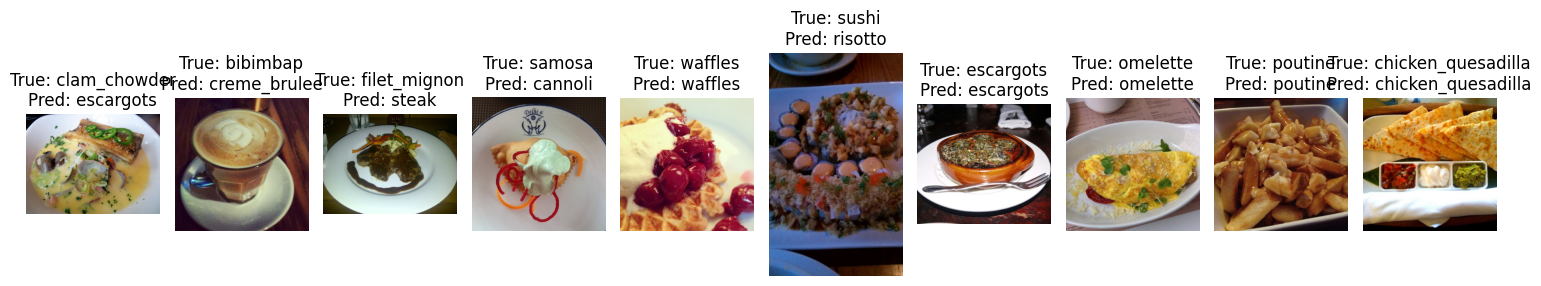

In [ ]:
# Visualización de predicciones del modelo entrenado en Food101
# Este código muestra ejemplos del conjunto de validación con sus etiquetas verdaderas y predicciones
import copy; import os; import peft; import torch; from torch import nn; import torch.nn.functional as F
os.environ["BITSANDBYTES_NOWELCOME"] = "1" # ignore bnb warnings
import matplotlib.pyplot as plt

num_examples_to_show = 10
plt.figure(figsize=(15, 5))

for i in range(num_examples_to_show):
    # Obtener una muestra del conjunto de validación
    sample = val_ds[i]
    original_image = sample["image"]
    pixel_values = sample["pixel_values"]
    true_label_id = sample["label"]
    true_label_name = id2label[true_label_id]

    # Preparar para la predicción del modelo
    # pixel_values necesita ser un batch, así que añadimos una dimensión de batch
    inputs = pixel_values.unsqueeze(0).to(device)

    # Realizar predicción (sin calcular gradientes para ahorrar memoria)
    with torch.no_grad():
        outputs = lora_model(inputs)
    logits = outputs.logits
    # Obtener la clase predicha (índice con mayor probabilidad)
    predicted_label_id = torch.argmax(logits, dim=-1).item()
    predicted_label_name = id2label[predicted_label_id]

    # Mostrar imagen y predicción
    plt.subplot(1, num_examples_to_show, i + 1)
    plt.imshow(original_image)
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Importación de librerías para el ejercicio con CIFAR10
import numpy as np; import torch; import transformers; import evaluate

In [ ]:
# Usamos el mismo modelo ViT pre-entrenado que en el ejemplo anterior
model_checkpoint = "google/vit-base-patch16-224-in21k"

In [ ]:
# Cargar el dataset CIFAR10
# CIFAR10 contiene 10 clases de objetos: avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco, camión
# Usamos solo un subconjunto para acelerar el entrenamiento en este ejemplo
# En producción, usaríamos el dataset completo: train[:50000] y test[:10000]
from datasets import load_dataset
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:1000]']) # mucho menos para pruebas

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# Crear mapeos entre etiquetas y IDs para CIFAR10 (10 clases)
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

In [ ]:
# Cargar el procesador de imágenes para preprocesar las imágenes de CIFAR10
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
# Definir transformaciones para CIFAR10
# Nota: CIFAR10 usa la clave "img" en lugar de "image" para las imágenes
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop,
 Resize, ToTensor)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose([RandomResizedCrop(image_processor.size["height"]),
 RandomHorizontalFlip(), ToTensor(), normalize])
val_transforms = Compose([Resize(image_processor.size["height"]), CenterCrop(image_processor.size["height"]),
 ToTensor(), normalize])

# Funciones de preprocesamiento (notar que usamos "img" en lugar de "image")
def preprocess_train(example_batch):
 example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["img"]]
 return example_batch
def preprocess_val(example_batch):
 example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["img"]]
 return example_batch

# Aplicar transformaciones a los datasets
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_val)

In [ ]:
# Cargar el modelo ViT adaptado para clasificación de CIFAR10 (10 clases)
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
model = AutoModelForImageClassification.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Configurar LoRA para CIFAR10 (misma configuración que en Food101)
from peft import LoraConfig, get_peft_model
config = LoraConfig(
 r=16,
 lora_alpha=16,
 target_modules=["query", "value"],
 lora_dropout=0.1,
 bias="none",
 modules_to_save=["classifier"])
# Aplicar LoRA al modelo
lora_model = get_peft_model(model, config)

In [ ]:
# Configurar argumentos de entrenamiento para CIFAR10
# Nota: learning_rate más bajo (5e-5) y warmup_ratio añadido comparado con Food101
model_name = model_checkpoint.split("/")[-1]
batch_size = 32  # Batch size más pequeño que en Food101

args = TrainingArguments(
 f"{model_name}-finetuned-lora-cifar10",  # Directorio de salida
 remove_unused_columns=False,
 eval_strategy = "epoch",  # Evaluar cada época
 save_strategy = "epoch",  # Guardar cada época
 learning_rate=5e-5,  # Learning rate más conservador
 per_device_train_batch_size=batch_size,
 gradient_accumulation_steps=4,  # Acumular gradientes de 4 lotes
 per_device_eval_batch_size=batch_size,
 num_train_epochs=10,  # 10 épocas (en el PDF se usan 3, pero aquí hay 10)
 warmup_ratio=0.1,  # Calentamiento: aumentar LR gradualmente en el 10% inicial del entrenamiento
 logging_steps=10,
 load_best_model_at_end=True,  # Cargar el mejor modelo al finalizar
 metric_for_best_model="accuracy",
 push_to_hub=False)

In [ ]:
# Configurar métrica de evaluación (accuracy)
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
 """Computes accuracy on a batch of predictions"""
 predictions = np.argmax(eval_pred.predictions, axis=1)
 return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
# Función para agrupar ejemplos en lotes
def collate_fn(examples):
 pixel_values = torch.stack([example["pixel_values"] for example in examples])
 labels = torch.tensor([example["label"] for example in examples])
 return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Crear el Trainer para CIFAR10
# Nota: usamos test_ds como eval_dataset (en lugar de val_ds) ya que no dividimos train/val
trainer = Trainer(
 lora_model,
 args,
 train_dataset=train_ds,
 eval_dataset=test_ds,  # Evaluar en el conjunto de test
 processing_class=image_processor,
 compute_metrics=compute_metrics,
 data_collator=collate_fn)

In [ ]:
# Iniciar el entrenamiento del modelo con LoRA para CIFAR10
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.200500,2.171327,0.535000
2,2.114500,2.080657,0.747000
3,2.031300,1.983426,0.849000
4,1.925400,1.877904,0.896000
5,1.819800,1.768114,0.916000
6,1.721000,1.668211,0.928000
7,1.624200,1.588781,0.932000
8,1.614400,1.532384,0.935000
9,1.560800,1.500448,0.935000
10,1.529600,1.489583,0.935000


In [ ]:
# Mostrar métricas finales del entrenamiento en CIFAR10
trainer.log_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =         10.0
  total_flos               = 3633890367GF
  train_loss               =       1.8434
  train_runtime            =   0:07:43.49
  train_samples_per_second =      107.876
  train_steps_per_second   =        0.863


In [ ]:
# Evaluar el modelo final en el conjunto de test de CIFAR10
# Esto nos da la precisión final y el coste temporal del entrenamiento
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =      0.935
  eval_loss               =     1.5324
  eval_runtime            = 0:00:06.00
  eval_samples_per_second =    166.544
  eval_steps_per_second   =      5.329


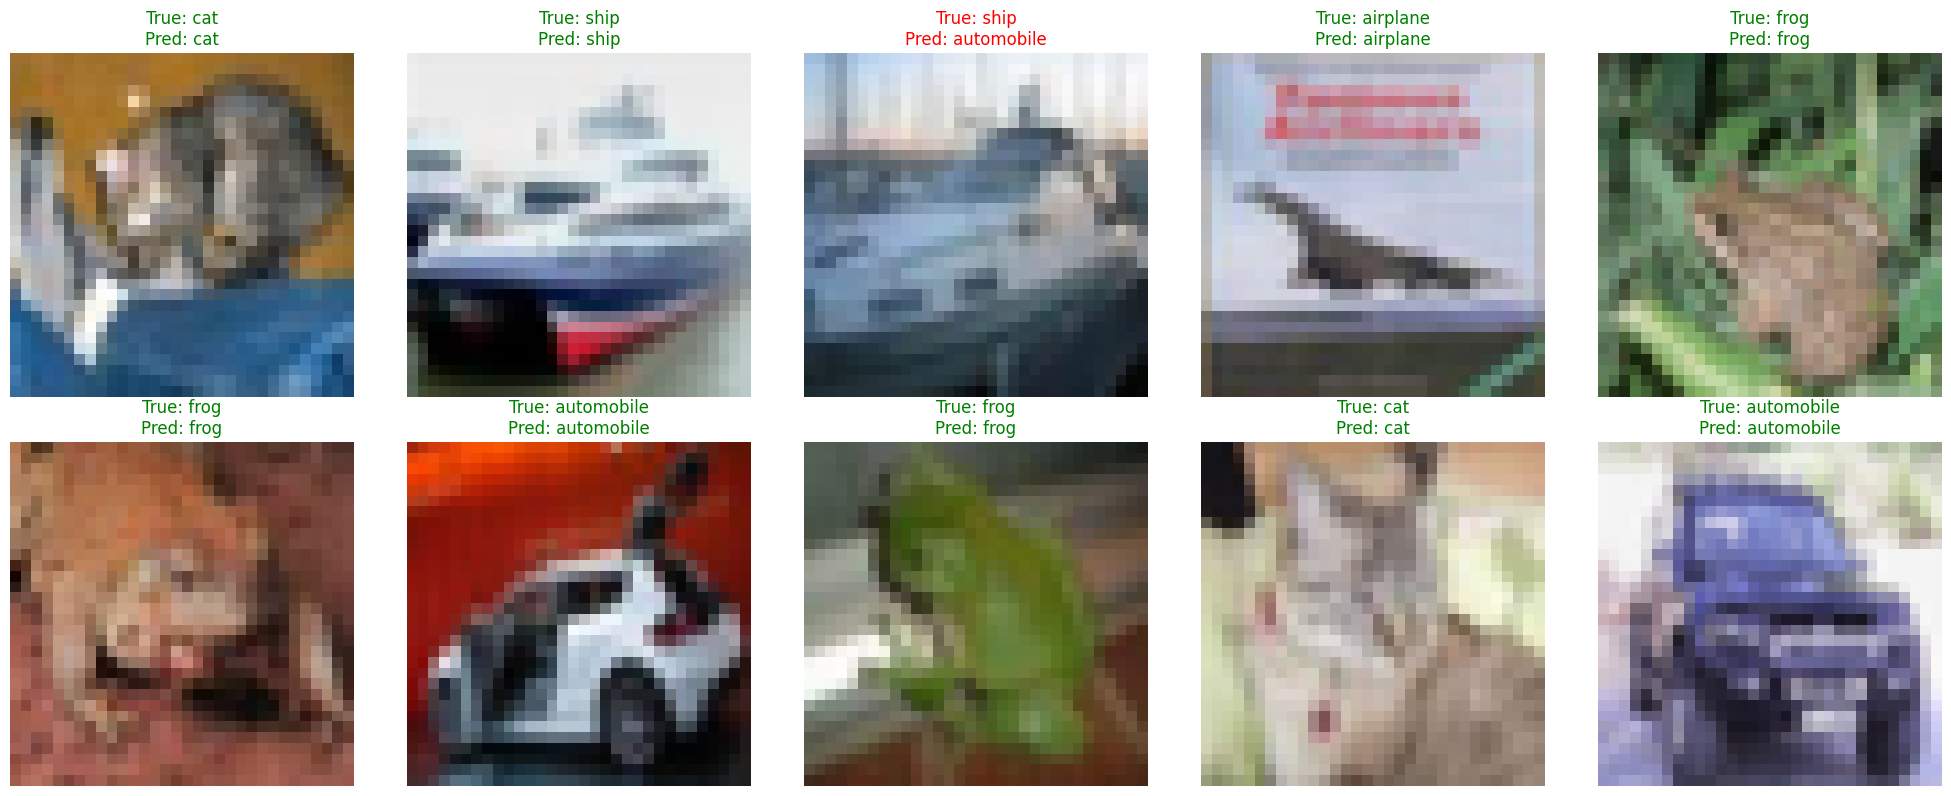

In [ ]:
# Visualización de predicciones del modelo entrenado en CIFAR10
# Muestra ejemplos del conjunto de test con etiquetas verdaderas y predicciones
# Las etiquetas en verde indican predicciones correctas, en rojo predicciones incorrectas
import matplotlib.pyplot as plt

num_examples_to_show = 10  # Número de ejemplos a mostrar
plt.figure(figsize=(20, 8))

for i in range(num_examples_to_show):
    # Obtener una muestra del conjunto de test (test_ds para CIFAR-10)
    sample = test_ds[i]
    original_image = sample["img"]  # Para CIFAR-10, la clave de imagen es 'img'
    pixel_values = sample["pixel_values"]
    true_label_id = sample["label"]
    true_label_name = id2label[true_label_id]

    # Preparar para la predicción del modelo
    # pixel_values necesita ser un batch, así que añadimos una dimensión de batch
    inputs = pixel_values.unsqueeze(0).to(device)

    # Realizar predicción (sin calcular gradientes)
    with torch.no_grad():
        outputs = lora_model(inputs)
    logits = outputs.logits
    predicted_label_id = torch.argmax(logits, dim=-1).item()
    predicted_label_name = id2label[predicted_label_id]

    # Mostrar imagen y predicción
    # Ajustar el layout del subplot para mejor visualización
    plt.subplot(2, num_examples_to_show // 2, i + 1)
    plt.imshow(original_image)
    # Color verde si la predicción es correcta, rojo si es incorrecta
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}",
              color="green" if true_label_id == predicted_label_id else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()